In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow_decision_forests as tfdf

# internal modules
import config
import util

from sklearn.pipeline import Pipeline

2024-07-06 17:47:23.387651: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 17:47:23.387895: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 17:47:23.389827: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 17:47:23.413557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 17:47:23.816419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [4]:
X_train = pd.read_csv(config.jn_datapath + 'train.csv')
print(f'shape of the dataframe is: {X_train.shape}')
X_train.head()

shape of the dataframe is: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
categorical_vars = X_train.select_dtypes(include='O').columns.to_list()
print(f'length of the categorical variables is: {len(categorical_vars)}\n')
print(categorical_vars)

length of the categorical variables is: 43

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [6]:
numerical_vars = X_train.select_dtypes(include='number').columns.to_list()
print(f'length of the numerical variables is: {len(numerical_vars)}\n')
print(numerical_vars)

length of the numerical variables is: 38

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


<Axes: >

Text(0, 0.5, 'proportion of missing values')

Text(0.5, 1.0, 'proportion of missing values by columns')

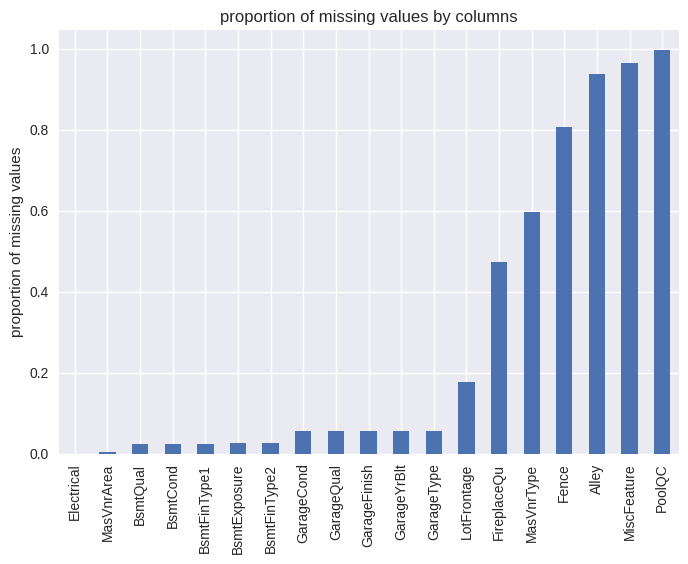

In [7]:
# proportion of missing values
with plt.style.context('seaborn'):
    missing_value_prop = X_train.isna().mean()
    missing_value_prop.where(missing_value_prop > 0).dropna().sort_values().plot.bar(rot=90)
    plt.ylabel('proportion of missing values')
    plt.title('proportion of missing values by columns')
    plt.show()

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_8067/1076904623.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['SalePrice'], color='g', bins=100, hist_kws={'alpha':0.4})


<Axes: xlabel='SalePrice', ylabel='Density'>

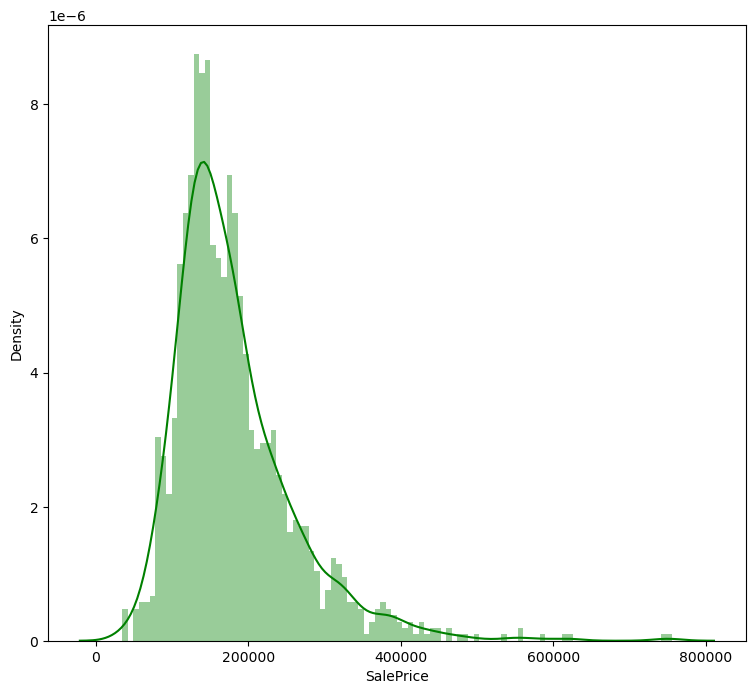

In [9]:
# House price distribution
print(X_train['SalePrice'].describe())
obj = plt.figure(figsize=(9,8))
sns.distplot(X_train['SalePrice'], color='g', bins=100, hist_kws={'alpha':0.4})
plt.show()

In [10]:
X_train.drop(labels=['Id'], axis=1, inplace=True)

# Numerical data distribution

In [11]:
X_num = X_train.select_dtypes('number')
X_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

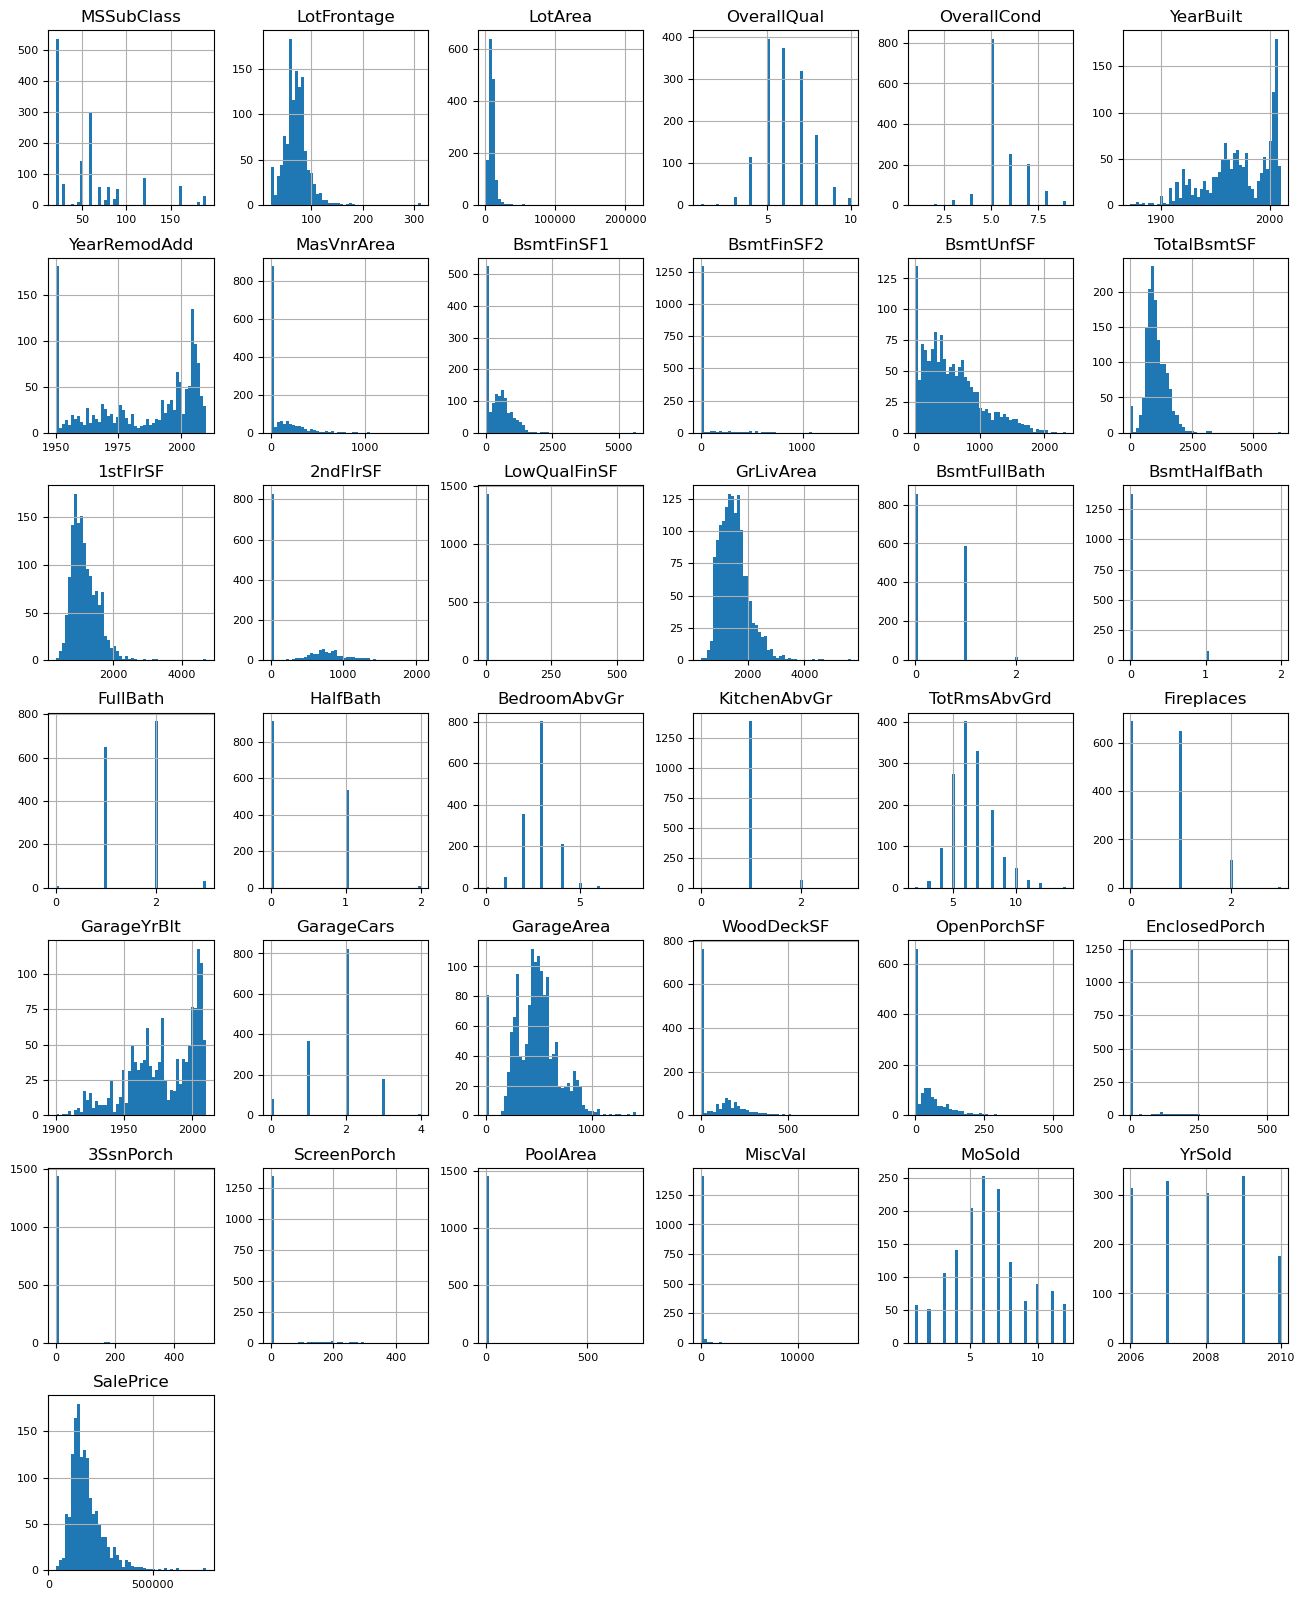

In [12]:
X_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [13]:
def split_dataset(data, test_ratio=0.3):
    test_indices = np.random.rand(len(X_train)) < test_ratio
    return data[~test_indices], data[test_indices]

train_dataset, test_dataset = split_dataset(X_train)
print("examples in train: {} and examples in test: {}".format(len(train_dataset), len(test_dataset)))

examples in train: 978 and examples in test: 482


In [14]:
# convert the data to tensorflow datasets format

label= 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_dataset, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataset, label=label, task=tfdf.keras.Task.REGRESSION)

2024-07-06 17:47:27.003144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-06 17:47:27.005045: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [16]:
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=['mse'])
rf

Use /tmp/tmpswgi4yhj as temporary training directory


In [17]:
# training the model
rf.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:01.862355. Found 978 examples.
Training model...
Model trained in 0:00:00.286264
Compiling model...


[INFO 24-07-06 17:47:29.2151 IST kernel.cc:1233] Loading model from path /tmp/tmpswgi4yhj/model/ with prefix 3f8c07c631314c93
[INFO 24-07-06 17:47:29.2836 IST decision_forest.cc:734] Model loaded with 300 root(s), 93014 node(s), and 74 input feature(s).
[INFO 24-07-06 17:47:29.2836 IST abstract_model.cc:1362] Engine "RandomForestOptPred" built
[INFO 24-07-06 17:47:29.2836 IST kernel.cc:1061] Use fast generic engine


Model compiled.


In [18]:
tfdf.model_plotter.plot_model(rf, tree_idx=0, max_depth=3)

'\n<script src="https://d3js.org/d3.v6.min.js"></script>\n<div id="tree_plot_e7358c0d2ece4077825974465d1f6445"></div>\n<script>\n/*\n * Copyright 2021 Google LLC.\n * Licensed under the Apache License, Version 2.0 (the "License");\n * you may not use this file except in compliance with the License.\n * You may obtain a copy of the License at\n *\n *     https://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an "AS IS" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\n\n/**\n *  Plotting of decision trees generated by TF-DF.\n *\n *  A tree is a recursive structure of node objects.\n *  A node contains one or more of the following components:\n *\n *    - A value: Representing the output of the node. If the node is not a leaf,\

In [19]:
# visualizing the model.
with open(config.jn_plotpath + 'tree_102.html', 'w') as fh:
    fh.write(tfdf.model_plotter.plot_model(rf, tree_idx=102, max_depth=3))

17940

Text(0.5, 0, 'Number of trees')

Text(0, 0.5, 'RMSE (out-of-bag)')

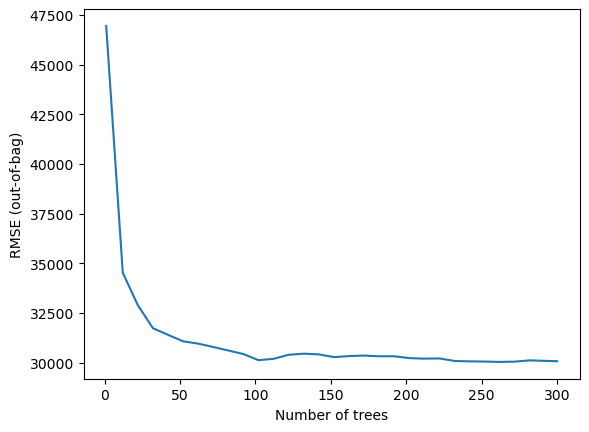

In [20]:
# Evaluate the model
inspector = rf.make_inspector()
logs = inspector.training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel('Number of trees')
plt.ylabel('RMSE (out-of-bag)')
plt.show()

In [26]:
inspector.variable_importances()

{'INV_MEAN_MIN_DEPTH': [("OverallQual" (1; #62), 0.2540025868725824),
  ("Neighborhood" (4; #59), 0.21369169244884437),
  ("GrLivArea" (1; #38), 0.201193200009232),
  ("TotalBsmtSF" (1; #73), 0.13610281704994906),
  ("1stFlrSF" (1; #0), 0.13025285529015665),
  ("ExterQual" (4; #22), 0.12836296256219207),
  ("GarageArea" (1; #31), 0.1232794729133044),
  ("GarageCars" (1; #32), 0.1222287797124183),
  ("BsmtFinSF1" (1; #8), 0.1149036612579085),
  ("2ndFlrSF" (1; #1), 0.1138876555627526),
  ("YearBuilt" (1; #76), 0.11300018220322972),
  ("KitchenQual" (4; #44), 0.11041772148926132),
  ("LotArea" (1; #47), 0.1098627159718392),
  ("YearRemodAdd" (1; #77), 0.10963705108234313),
  ("Fireplaces" (1; #27), 0.10780014866183663),
  ("TotRmsAbvGrd" (1; #72), 0.10746313194383068),
  ("GarageFinish" (4; #34), 0.10739724043655549),
  ("CentralAir" (4; #16), 0.10696999762767824),
  ("BsmtFinType1" (4; #10), 0.10686232838761862),
  ("FullBath" (1; #29), 0.10637403709864668),
  ("Exterior2nd" (4; #24), 0

In [27]:
# evaluate the model with test dataset/validation dataset
evaluation = rf.evaluate(test_ds, return_dict=True)
for key, value in evaluation.items():
    print(f"{key}: {value:.4f}")

1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - mse: 836047104.0000
loss: 0.0000
mse: 836047104.0000


In [45]:
feature_names = []
feature_importances = []
for item in inspector.variable_importances()['NUM_AS_ROOT']:
    feature_names.append(item[0].name)
    feature_importances.append(item[1])

<BarContainer object of 14 artists>

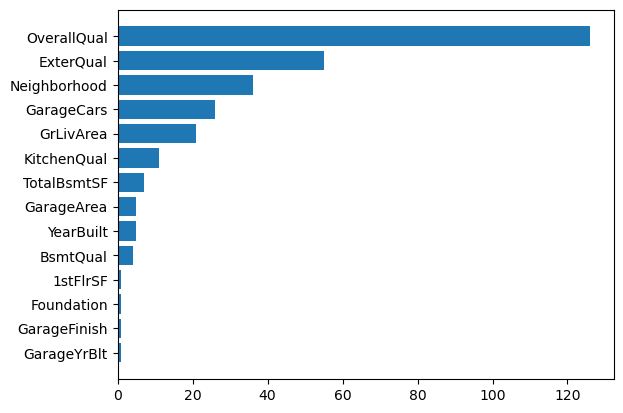

In [50]:
plt.barh(feature_names, feature_importances)
plt.gca().invert_yaxis()
plt.show()

In [48]:
feature_ranks

range(0, 14)

In [49]:
feature_ranks

range(0, 14)